# Face Recognition System - Experimentation Notebook

This notebook demonstrates key components of the face recognition system:
- Loading and visualizing face images
- Extracting HOG features
- Building and training neural network models
- Evaluating model performance

You can use this notebook to experiment with different parameters and approaches.

## Setup and Imports

In [7]:
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
import h5py
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Add the src directory to the path so we can import our modules
sys.path.append('../src')
from utils import preprocess_image, load_from_h5  # type: ignore

# Configure plot style
plt.style.use('ggplot')
%matplotlib inline

## 1. Load and Visualize Face Images

Let's load some face images from our dataset and visualize them.

People in dataset: ['Diego Trigo', 'Santiago Iturri']


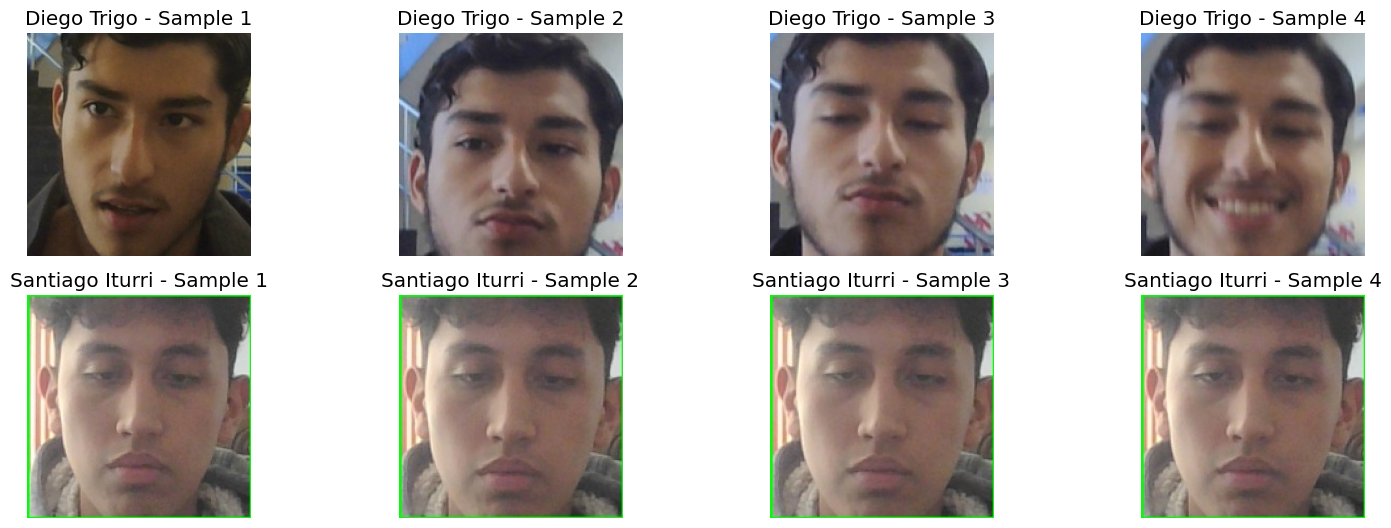

In [8]:
# Path to raw data
raw_data_dir = '../data/raw'

# Get list of people in dataset
people = [d for d in os.listdir(raw_data_dir) if os.path.isdir(os.path.join(raw_data_dir, d))]
print(f"People in dataset: {people}")

# Function to load and display sample images
def show_sample_faces(num_people=3, samples_per_person=4):
    plt.figure(figsize=(15, 4 * min(num_people, len(people))))
    
    for i, person in enumerate(people[:num_people]):
        person_dir = os.path.join(raw_data_dir, person)
        image_files = [f for f in os.listdir(person_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for j, img_file in enumerate(image_files[:samples_per_person]):
            img_path = os.path.join(person_dir, img_file)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                plt.subplot(num_people, samples_per_person, i*samples_per_person + j + 1)
                plt.imshow(image)
                plt.title(f"{person} - Sample {j+1}")
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample faces
if people:
    show_sample_faces()
else:
    print("No data available yet. Please run face capture first.")

## 2. HOG Feature Extraction

Let's visualize the HOG features for a sample face image.

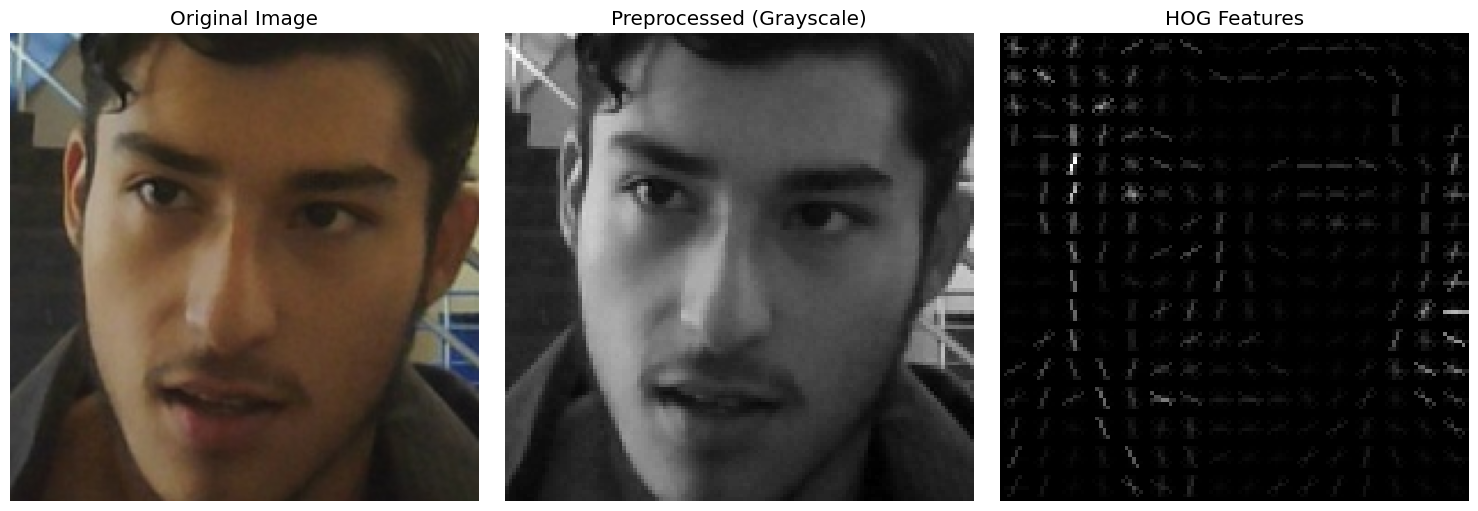

HOG feature vector length: 8100


In [9]:
def visualize_hog(image_path):
    """Visualize HOG features for a given image"""
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image: {image_path}")
        return
    
    # Preprocess image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (128, 128))
    normalized = resized / 255.0
    
    # Extract HOG features with visualization
    hog_features, hog_image = hog(
        normalized,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True
    )
    
    # Plot original and HOG visualization
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(normalized, cmap='gray')
    axs[1].set_title('Preprocessed (Grayscale)')
    axs[1].axis('off')
    
    axs[2].imshow(hog_image, cmap='gray')
    axs[2].set_title('HOG Features')
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return hog_features

# Find a sample image to visualize
sample_image_path = None
if people:
    person = people[0]
    person_dir = os.path.join(raw_data_dir, person)
    image_files = [f for f in os.listdir(person_dir) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if image_files:
        sample_image_path = os.path.join(person_dir, image_files[0])

if sample_image_path:
    hog_features = visualize_hog(sample_image_path)
    print(f"HOG feature vector length: {len(hog_features)}")
else:
    print("No sample images available yet. Please run face capture first.")

## 3. Load Processed Dataset

Let's load the processed dataset containing HOG features and labels.

Loaded dataset with 118 samples
Feature vector shape: (118, 8100)


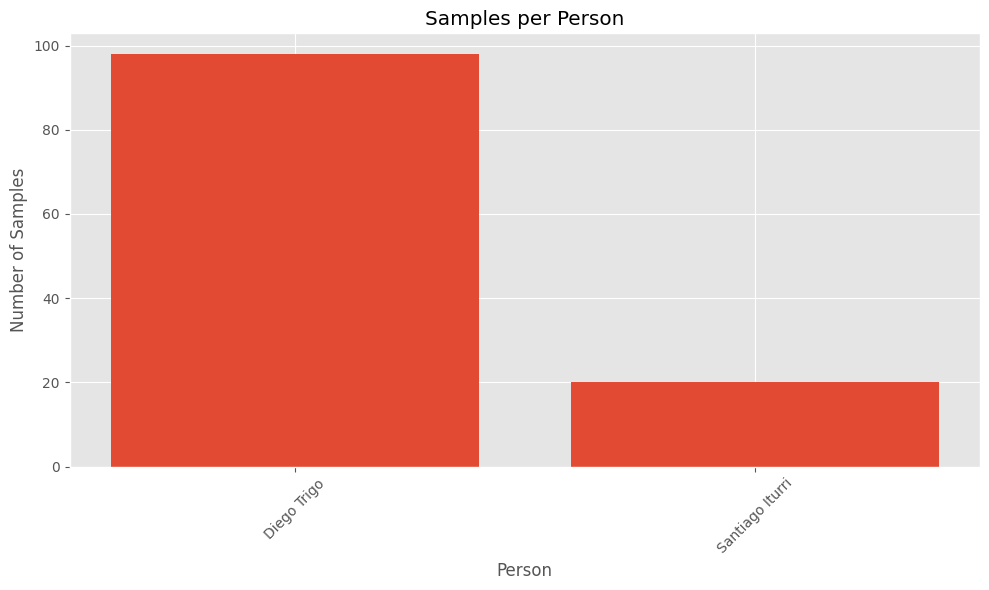

In [10]:
# Path to processed features
features_file = '../data/processed/face_features.h5'

if os.path.exists(features_file):
    # Load features and labels
    features, labels = load_from_h5(features_file)
    
    print(f"Loaded dataset with {len(features)} samples")
    print(f"Feature vector shape: {features.shape}")
    
    # Count samples per person
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts)
    plt.title('Samples per Person')
    plt.xlabel('Person')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Processed dataset not found. Please run feature extraction first.")

## 4. Train and Evaluate Neural Network Model

Now let's train a neural network model on the HOG features and evaluate its performance.

Training set size: 94 samples
Test set size: 24 samples


C:\Users\SANTI\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │     4,147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,315,649 (16.46 MB)

 Trainable params: 4,313,857 (16.46 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/20


C:\Users\SANTI\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\SANTI\AppData\Roaming\Python\Python312\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.1597 - loss: 0.0000e+00 - val_accuracy: 0.1053 - val_loss: 0.0000e+00
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.1597 - loss: 0.0000e+00 - val_accuracy: 0.1053 - val_loss: 0.0000e+00
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1949 - loss: 0.0000e+00 - val_accuracy: 0.1053 - val_loss: 0.0000e+00
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1949 - loss: 0.0000e+00 - val_accuracy: 0.1053 - val_loss: 0.0000e+00
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1715 - loss: 0.0000e+00 - val_accuracy: 0.1053 - val_loss: 0.0000e+00
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1715 - loss: 0.0000e+00 - val_accuracy: 0.1053 - val_loss: 0.0000e+00
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1715 - loss: 0.0000e+00 - val_accuracy: 0.1053 - val_loss: 0.0000e+00
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1715 - loss: 0.

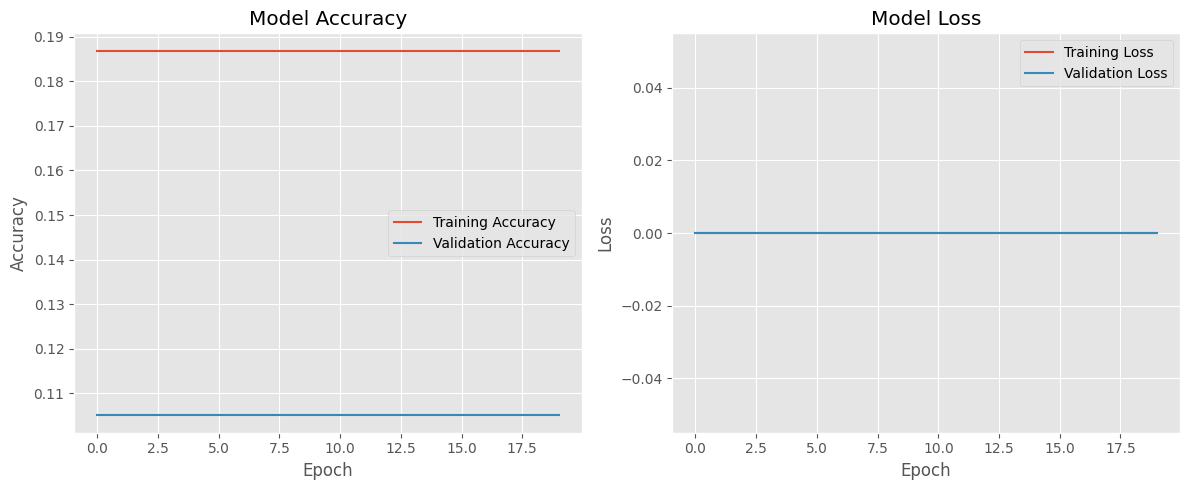

Test Accuracy: 0.1667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


C:\Users\SANTI\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (24, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


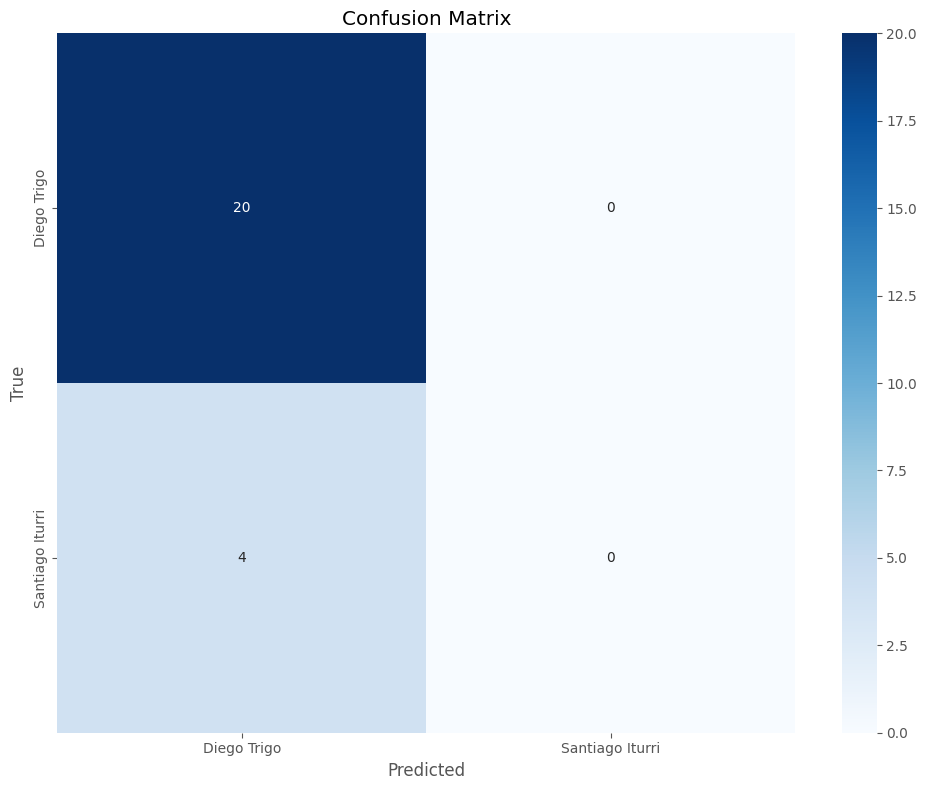


Classification Report:
                 precision    recall  f1-score   support

    Diego Trigo       0.83      1.00      0.91        20
Santiago Iturri       0.00      0.00      0.00         4

       accuracy                           0.83        24
      macro avg       0.42      0.50      0.45        24
   weighted avg       0.69      0.83      0.76        24



C:\Users\SANTI\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SANTI\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SANTI\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [11]:
# Only run if we have features loaded
if 'features' in locals() and features is not None:
    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    
    # Convert to one-hot encoding
    label_binarizer = LabelBinarizer()
    one_hot_labels = label_binarizer.fit_transform(encoded_labels)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features, one_hot_labels, test_size=0.2, random_state=42, stratify=one_hot_labels
    )
    
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    
    # Build model
    model = Sequential([
        # Input layer
        Dense(512, activation='relu', input_shape=(features.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Hidden layers
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Output layer
        Dense(one_hot_labels.shape[1], activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Model summary
    model.summary()
    
    # Train model (with a smaller number of epochs for the notebook)
    history = model.fit(
        X_train, y_train,
        epochs=20,  # Reduced for the notebook
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = y_test.flatten()  # Simply flatten the array instead of using argmax
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
else:
    print("No features loaded. Please load the processed dataset first.")

## 5. Experiment with HOG Parameters

Let's experiment with different HOG parameters to see how they affect feature extraction.

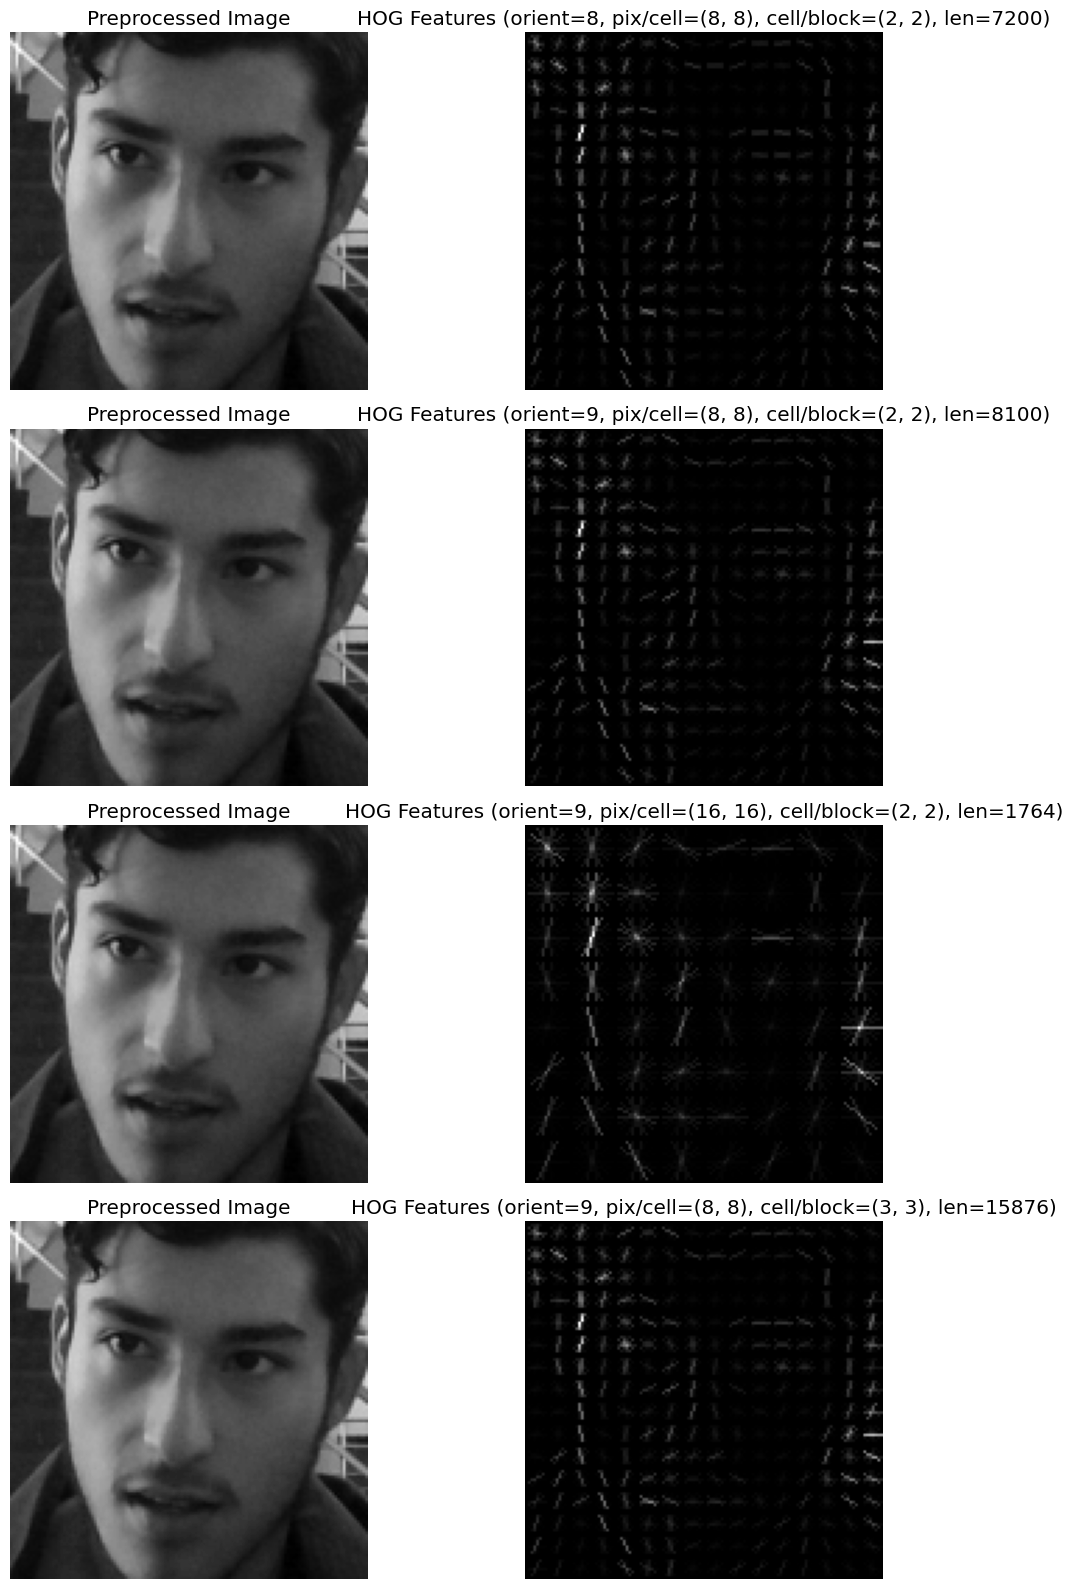

In [12]:
def extract_hog_with_params(image, orientations, pixels_per_cell, cells_per_block):
    """Extract HOG features with given parameters and visualize"""
    features, hog_image = hog(
        image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=True
    )
    
    return features, hog_image

# Find a sample image
if 'sample_image_path' in locals() and sample_image_path:
    # Load and preprocess image
    image = cv2.imread(sample_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (128, 128))
    normalized = resized / 255.0
    
    # Define different parameter combinations
    hog_params = [
        {'orientations': 8, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)},
        {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)},
        {'orientations': 9, 'pixels_per_cell': (16, 16), 'cells_per_block': (2, 2)},
        {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}
    ]
    
    # Plot results
    fig, axs = plt.subplots(len(hog_params), 2, figsize=(12, 4 * len(hog_params)))
    
    for i, params in enumerate(hog_params):
        features, hog_image = extract_hog_with_params(
            normalized, 
            params['orientations'], 
            params['pixels_per_cell'], 
            params['cells_per_block']
        )
        
        # Display original image
        axs[i, 0].imshow(normalized, cmap='gray')
        axs[i, 0].set_title('Preprocessed Image')
        axs[i, 0].axis('off')
        
        # Display HOG image
        axs[i, 1].imshow(hog_image, cmap='gray')
        title = f"HOG Features (orient={params['orientations']}, " \
                f"pix/cell={params['pixels_per_cell']}, " \
                f"cell/block={params['cells_per_block']}, " \
                f"len={len(features)})"
        axs[i, 1].set_title(title)
        axs[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No sample image available. Please run face capture first.")

## 6. Save and Load Model

Demonstrate how to save and load a trained model.

In [13]:
# Only run if we have a model
if 'model' in locals() and 'label_encoder' in locals():
    # Create models directory if it doesn't exist
    models_dir = '../models'
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    
    # Save model
    model_path = os.path.join(models_dir, 'notebook_model.h5')
    model.save(model_path)
    print(f"Model saved to {model_path}")
    
    # Save label encoder classes
    encoder_path = os.path.join(models_dir, 'notebook_label_encoder.npy')
    np.save(encoder_path, label_encoder.classes_)
    print(f"Label encoder classes saved to {encoder_path}")
    
    # Load model
    loaded_model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully")
    
    # Load label encoder classes
    loaded_classes = np.load(encoder_path, allow_pickle=True)
    print("Label encoder classes loaded successfully")
    print(f"Classes: {loaded_classes}")
else:
    print("No model to save. Please train a model first.")

Model saved to ../models\notebook_model.h5
Label encoder classes saved to ../models\notebook_label_encoder.npy
Model loaded successfully
Label encoder classes loaded successfully
Classes: ['Diego Trigo' 'Santiago Iturri']
